## Udacity Machine Learning Nanodegree Capstone Project ##

**Elo Merchant Category Recommendation**

The challenge is to develop a model that will predict a *loyalty score* for each customer represented in the **test.csv**.

The flow of the project will be in the following manner:
* Exploring the Data
* Data preprocessing/cleaning
* Evaluate Algorithm
* Model tuning to improve results
* Final conclusion

### Exploring the data ###

**1.1 Loading Libraries and Data**

In [1]:
# Importing neccessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette
import datetime
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import time
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import gc
import warnings
from bayes_opt import BayesianOptimization

# Pretty display for notebooks

%matplotlib inline

/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Loading all the datasets

historical_trans = pd.read_csv('historical_transactions.csv')
new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')
merchants = pd.read_csv('merchants.csv')

# Loading the training and testing sets

training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [3]:
data_dict_training = pd.read_excel('Data_Dictionary.xlsx', sheet_name = 'train')
data_dict_hist_trans = pd.read_excel('Data_Dictionary.xlsx', sheet_name = 'history')
data_dict_new_merchant_trans = pd.read_excel('Data_Dictionary.xlsx', sheet_name = 'new_merchant_period')
data_dict_merchants = pd.read_excel('Data_Dictionary.xlsx', sheet_name = 'merchant')

**1.2  Explore the training data and test data**

In [4]:
# Display the first 5 records of the Training set
training_set.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [5]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [6]:
# Display the first 5 records of the Test set
test_set.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [7]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


**1.3 Dimension of data**

In [8]:
print("The training dataset has", training_set.shape[1], 'columns and ', training_set.shape[0], 'rows')
print("The test dataset has", test_set.shape[1], 'columns and ', test_set.shape[0], 'rows')

The training dataset has 6 columns and  201917 rows
The test dataset has 5 columns and  123623 rows


**1.4 Overview of the data**

In [9]:
# Calculate the number of cardholders in the training set
ncard_id_training = len(training_set)

#Calculate the number of cardholders in the test set
ncard_id_test = len(test_set)

# Calculate number of features for both the training and test sets
n_features = len(training_set.columns[: -1])

print("Total number of cardholders in the training set: {}".format(ncard_id_training))
print("Total number of cardholders in the test set: {}".format(ncard_id_test))
print("Number of features: {}".format(n_features))

Total number of cardholders in the training set: 201917
Total number of cardholders in the test set: 123623
Number of features: 5


**1.5 Statistical Summary**

In [10]:
print("Training set")
display(training_set.describe())

print("Test set")
display(test_set.describe())

Training set


,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


Test set


,feature_1,feature_2,feature_3
count,123623.00000,123623.000000,123623.000000
mean,3.10926,1.741796,0.564377
std,1.18911,0.749195,0.495840
min,1.00000,1.000000,0.000000
25%,2.00000,1.000000,0.000000
50%,3.00000,2.000000,1.000000
75%,4.00000,2.000000,1.000000
max,5.00000,3.000000,1.000000


**Exploration of the historical transaction data**

In [11]:
historical_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [12]:
print(historical_trans.shape)

(29112361, 14)


In [13]:
historical_trans.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

**Exploration of the new merchant transactions data**

In [14]:
new_merchant_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [15]:
print(new_merchant_trans.shape)

(1963031, 14)


In [16]:
new_merchant_trans.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

**Description of merchants data**

In [17]:
data_dict_merchants

,merchants.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anony...
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last acti...



**1.6 Exploratory Analysis - Data Visualization of the Training Data**

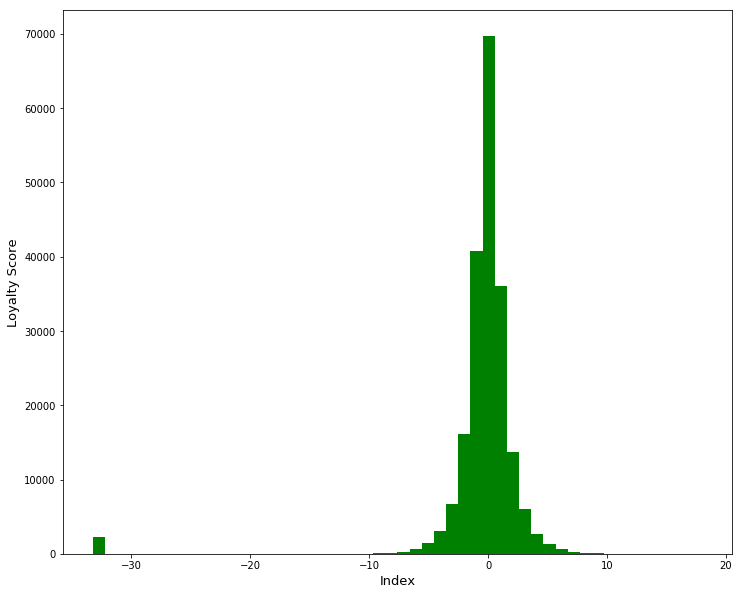

In [18]:
# Visualize the distribution of the data
plt.figure(figsize=(12, 10))
plt.hist(training_set.target.values, bins = 50, color = 'green')

plt.xlabel("Index", fontsize = 13)
plt.ylabel("Loyalty Score", fontsize = 13)

plt.show()

In [19]:
(training_set.target.values < -30).sum()

2207

The distribution of the target column in the training set is a normal distribution, except for a few outliers. The outliers make up only about 1% of the data.

Exploring the behaviour of the feature in relation with our **Target**.

Violin plot:

A violin plot is used to visualise the distribution of the data its probability density. The probability density function whose function at any given sample in the sample space can be interpreted as providing a relative likelihood that the value of the random variable would equal of the sample. The violin plot is a combination of a Box plot and a Density plot that is rotated and placed on each side, to show the distribution shape of the data. The thick black bar represents the interquartile range, the thin black line extended from it represents the 95% confidence intervals and the white dot is the median.

Box plots are limited in their display of the data, as their visual simplicity tends to hide significant details.

/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'target')

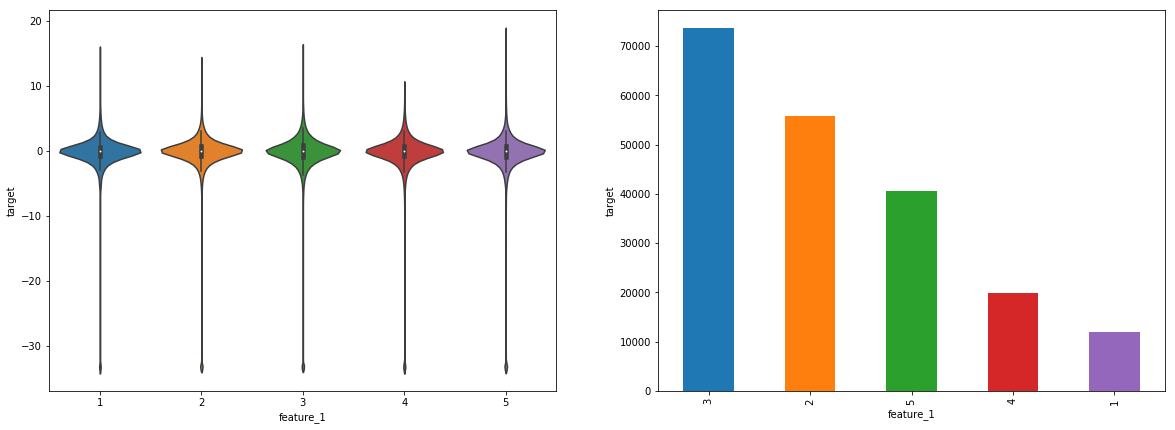

In [20]:
# Violin plot Feature 1
plt.figure(figsize = (20, 7))
plt.subplot(121)
sns.violinplot(training_set.feature_1, training_set.target)
plt.xlabel('feature_1')
plt.ylabel('target')

# Bar plot Feature 1
plt.subplot(122)
training_set['feature_1'].value_counts().plot(kind='bar')
plt.xlabel('feature_1')
plt.ylabel('target')

/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'target')

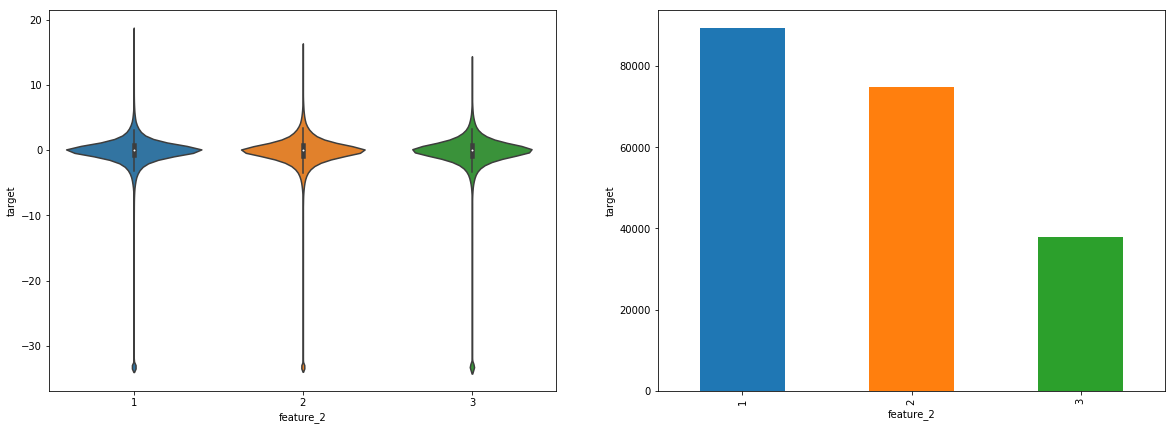

In [21]:
# Violin plot Feature 2
plt.figure(figsize = (20, 7))
plt.subplot(121)
sns.violinplot(training_set.feature_2, training_set.target)
plt.xlabel('feature_2')
plt.ylabel('target')

# Bar plot Feature 2
plt.subplot(122)
training_set['feature_2'].value_counts().plot(kind='bar')
plt.xlabel('feature_2')
plt.ylabel('target')

/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'target')

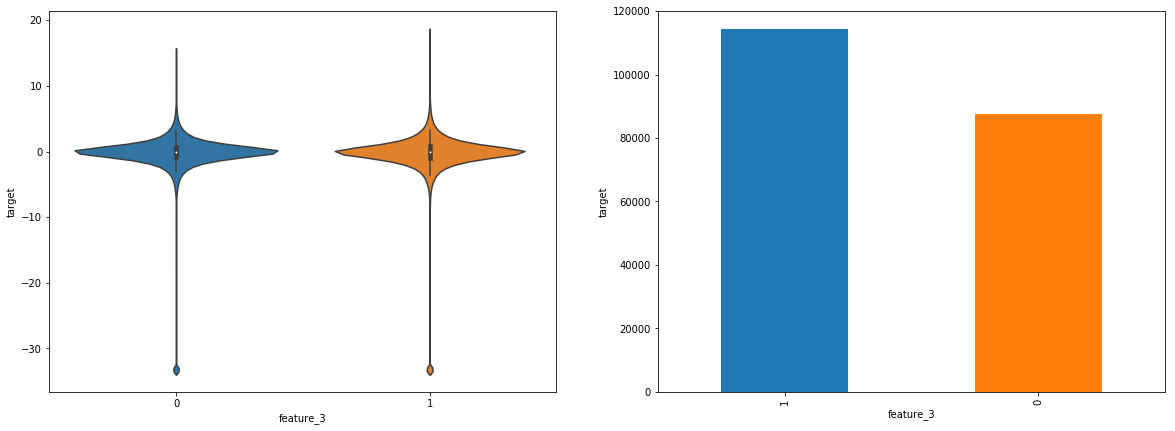

In [22]:
# Violin plot Feature 3
plt.figure(figsize = (20, 7))
plt.subplot(121)
sns.violinplot(training_set.feature_3, training_set.target)
plt.xlabel('feature_3')
plt.ylabel('target')

# Bar plot Feature 3
plt.subplot(122)
training_set['feature_3'].value_counts().plot(kind='bar')
plt.xlabel('feature_3')
plt.ylabel('target')

Observations for the training data set:

1. There are only a handful of different values for each of the three features.
2. All the values are discrete values.
3. All of the features are relatively evenly distributed

This suggests these features are categorical and have been label encoded. This analysis could also indicate that these features aren't good at predicting target values, we will likely need others features and features engineering to make better predictions.

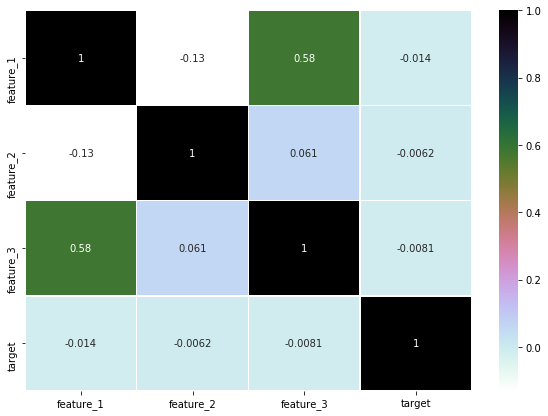

In [23]:
#Visualize correlations of features with a heatmap
plt.figure(figsize = (10,7))
sns.heatmap(training_set.corr(), annot = True, linewidths = 0.5, cmap = 'cubehelix_r')

## Prepare the data ##
### Data preprocessing/Cleaning ###

In this section, I will prepare the data by splitting the features and target/labels column, I will check for the quality of given data, and perform data cleaning. As this is a Kaggle dataset they have already split the data into a training set and a validation/test set to check the accuracy of the predictions.

**2.1 Data Cleaning**

Checking for any missing values in our datasets.

In [24]:
#Training Missing Values
total=training_set.isnull().sum().sort_values(ascending = False)
percentage=(training_set.isnull().sum()/training_set.isnull().count()*100).sort_values(ascending=False)

missing_data=pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
missing_data.head(10)

,Total,Percentage
target,0,0.0
feature_3,0,0.0
feature_2,0,0.0
feature_1,0,0.0
card_id,0,0.0
first_active_month,0,0.0


In [25]:
#Test missing values
total=test_set.isnull().sum().sort_values(ascending = False)
percentage=(test_set.isnull().sum()/test_set.isnull().count()*100).sort_values(ascending=False)

missing_data=pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
missing_data.head(10)

,Total,Percentage
first_active_month,1,0.000809
feature_3,0,0.000000
feature_2,0,0.000000
feature_1,0,0.000000
card_id,0,0.000000


In [26]:
#Historical Transactions missing values
total=historical_trans.isnull().sum().sort_values(ascending = False)
percentage=(historical_trans.isnull().sum()/historical_trans.isnull().count()*100).sort_values(ascending=False)

missing_data=pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
missing_data

,Total,Percentage
category_2,2652864,9.112500
category_3,178159,0.611970
merchant_id,138481,0.475678
subsector_id,0,0.000000
state_id,0,0.000000
purchase_date,0,0.000000
purchase_amount,0,0.000000
month_lag,0,0.000000
merchant_category_id,0,0.000000
installments,0,0.000000


In [27]:
#New merchant transactions missing values 
total=new_merchant_trans.isnull().sum().sort_values(ascending=False)
percentage=(new_merchant_trans.isnull().sum()/new_merchant_trans.isnull().count() * 100).sort_values(ascending=False)

missing_data=pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

missing_data

,Total,Percentage
category_2,111745,5.692473
category_3,55922,2.848758
merchant_id,26216,1.335486
subsector_id,0,0.000000
state_id,0,0.000000
purchase_date,0,0.000000
purchase_amount,0,0.000000
month_lag,0,0.000000
merchant_category_id,0,0.000000
installments,0,0.000000


**2.2 Identify feature and target columns**

In [28]:
#Formatting the date
for data in [training_set, test_set]:
    data['first_active_month'] = pd.to_datetime(data['first_active_month'])
    data['year'] = data['first_active_month'].dt.year
    data['month'] = data['first_active_month'].dt.month
    
    data['elasped_time'] = (datetime.date(2018, 2, 1) - data['first_active_month'].dt.date).dt.days

# Identifying the target columns
y_train = training_set['target']
training_set.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,elasped_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016,8,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,2017,9,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11,92


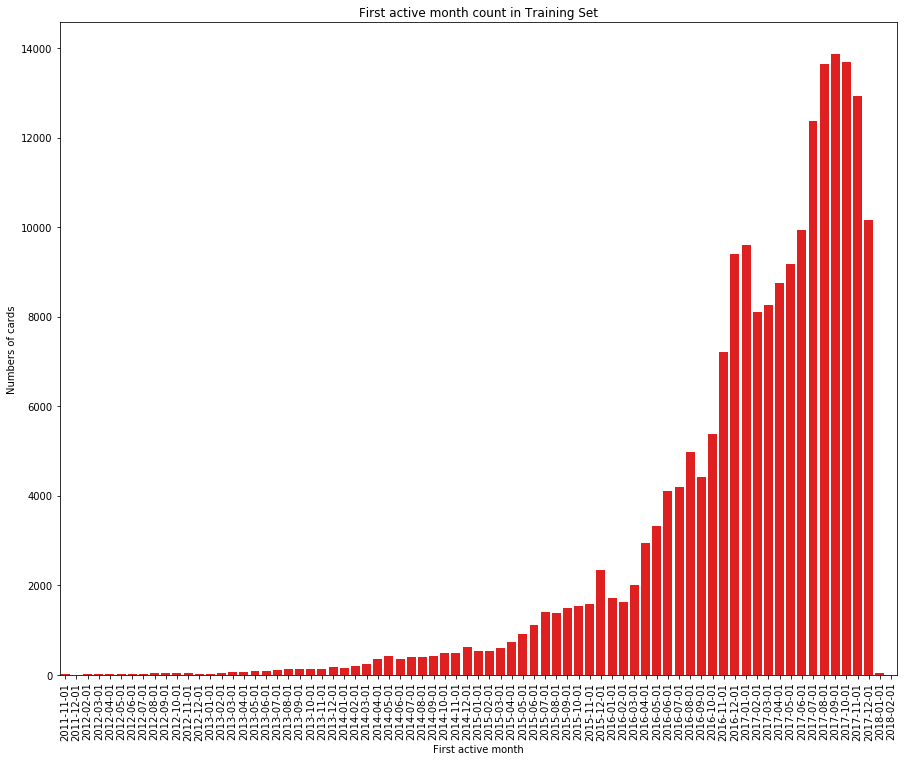

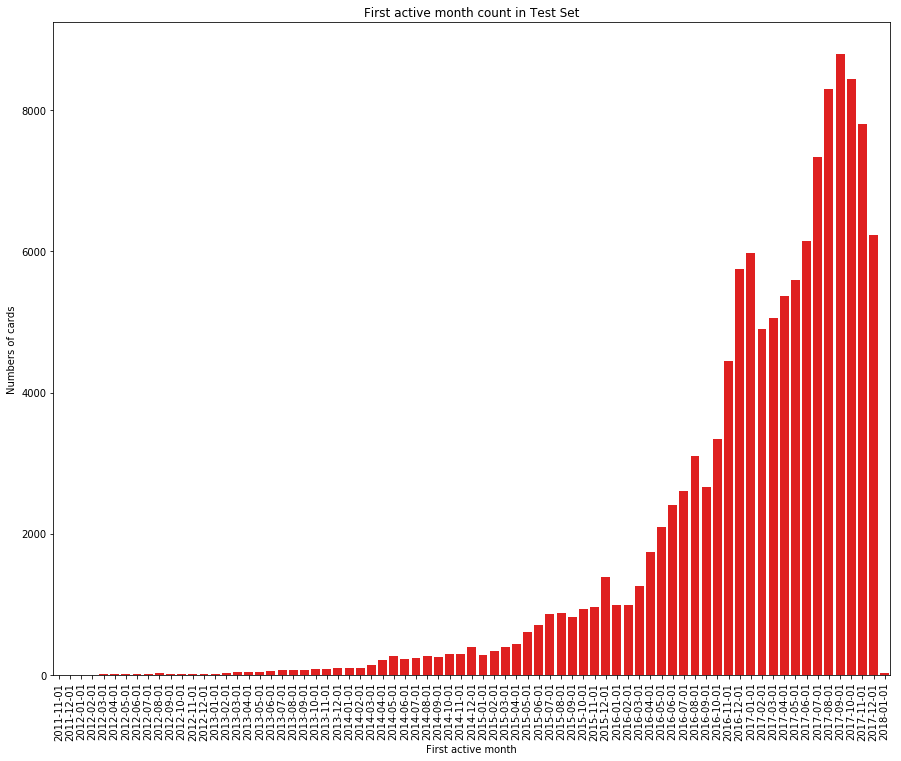

In [29]:
# Visualizing numbers of card and the amount of purchases
cnt_srs = training_set['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize = (15, 12))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 1, color = 'red')
plt.xticks(rotation = 'vertical')
plt.title('First active month count in Training Set')
plt.xlabel('First active month')
plt.ylabel('Numbers of cards')

plt.show()


cnt_srs = test_set['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize = (15, 12))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 1, color = 'red')
plt.xticks(rotation = 'vertical')
plt.title('First active month count in Test Set')
plt.xlabel('First active month')
plt.ylabel('Numbers of cards')

plt.show()

It is visible to see that most of the first purchases came in the years of 2016 and 2017 the trend started to increase, starting in 2011 and continued till 2014. In 2015 the number of purchases increase at a much faster rate than before, this could indicate the amount of trust that customer place in Elo services.

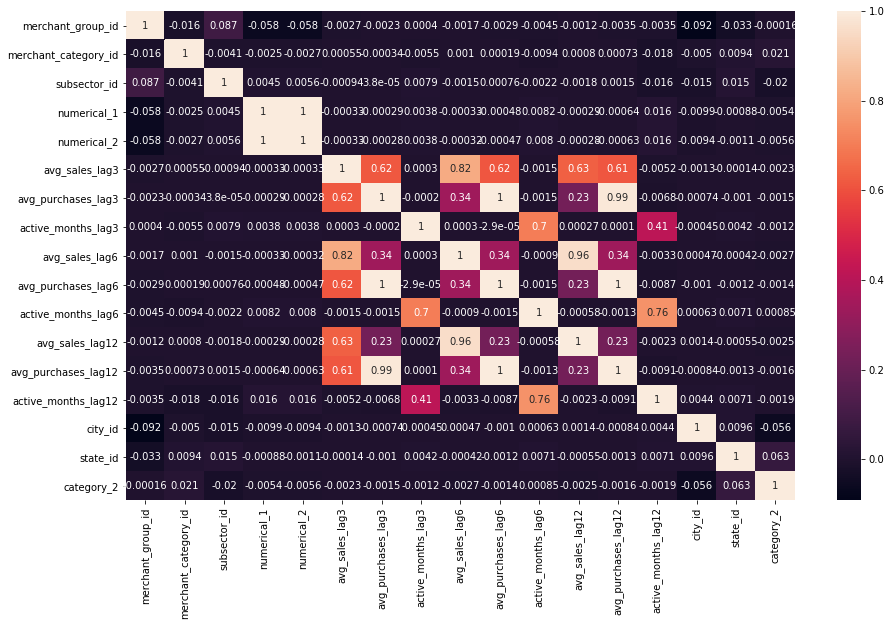

In [30]:
plt.figure(figsize=(15,9))
sns.heatmap(merchants.corr(), annot = True)

**2.3 Merging the datasets**

As was noted through the exploration of the training set we might need more features to make better predictions. To do this we need to merge the different datasets into one main dataset together in the following manner:

1. Convert any binary values.
2. Use the aggregation function to group multiple rows together to get one value.
3. Merge those aggregated columns on `card_id` which is a column that is shared on all three datasets.

In [31]:
# Converting the binary values
historical_trans['authorized_flag'] = historical_trans['authorized_flag'].map({'Y':1, 'N':0})

In [32]:
historical_trans.loc[:,'purchase_date']=pd.DatetimeIndex(historical_trans['purchase_date']).astype(np.int64)*1e-9

# aggregate function
agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
agg_history=historical_trans.groupby(['card_id']).agg(agg_func)
agg_history.columns=['hist_' + '-'.join(col).strip() for col in agg_history.columns.values]
agg_history.reset_index(inplace=True)

The features that I aggregated together were the following:

* authorized_flag
* merchant_id
* city_id
* purchase_amount
* installments
* purchase_date
* month_lag

I have choosen not add the features of categories 1, 2, or 3 because they seemed to share similar information to the feature 1, 2, and 3 that are already in the training and test datasets.

In [33]:
df = agg_history.groupby(['card_id']).size().reset_index(name = 'historical_trans_count')
agg_history = pd.merge(df, agg_history, on = 'card_id', how = 'left')

# Displaying the aggregated data
agg_history.head()

,card_id,historical_trans_count,hist_authorized_flag-sum,hist_authorized_flag-mean,hist_merchant_id-nunique,hist_city_id-nunique,hist_purchase_amount-sum,hist_purchase_amount-median,hist_purchase_amount-max,hist_purchase_amount-min,hist_purchase_amount-std,hist_installments-sum,hist_installments-median,hist_installments-max,hist_installments-min,hist_installments-std,hist_purchase_date-ptp,hist_month_lag-min,hist_month_lag-max
0,C_ID_00007093c1,1,114,0.765101,29,4,-76.845041,-0.587627,1.507069,-0.728876,0.298141,192,1.0,6,1,0.764900,32627654.0,-12,0
1,C_ID_0001238066,1,120,0.975610,65,18,-72.447201,-0.648184,0.768095,-0.734887,0.190235,198,1.0,10,-1,1.485637,13110825.0,-5,0
2,C_ID_0001506ef0,1,62,0.939394,28,3,-34.601879,-0.703707,1.493545,-0.740491,0.472284,1,0.0,1,0,0.123091,34460275.0,-13,0
3,C_ID_0001793786,1,189,0.875000,119,10,-36.786013,-0.487911,4.554145,-0.745405,0.836046,5,0.0,1,0,0.150723,24487497.0,-9,0
4,C_ID_000183fdda,1,137,0.951389,73,9,-68.837938,-0.661294,2.764788,-0.737892,0.524948,264,1.0,10,-1,2.118846,17492874.0,-6,0


In [34]:
# Merging the training, test dataset together with the historical_transactions dataset
training_set = pd.merge(training_set, agg_history, on = 'card_id', how = 'left')
test_set = pd.merge(test_set, agg_history, on = 'card_id', how = 'left')

In [35]:
# Displaying the new training set columns after the merge of the aggregated historical_transactions dataset
training_set.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,elasped_time,historical_trans_count,...,hist_purchase_amount-min,hist_purchase_amount-std,hist_installments-sum,hist_installments-median,hist_installments-max,hist_installments-min,hist_installments-std,hist_purchase_date-ptp,hist_month_lag-min,hist_month_lag-max
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,245,1,...,-0.739395,0.212139,4,0.0,1,0,0.123314,20977987.0,-8,0
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,396,1,...,-0.742400,0.384967,543,1.0,10,-1,1.510777,33717687.0,-12,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016,8,549,1,...,-0.730138,0.087380,0,0.0,0,0,0.000000,35635623.0,-13,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,2017,9,153,1,...,-0.740897,0.261624,84,1.0,3,-1,0.588974,13375339.0,-5,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11,92,1,...,-0.746156,1.352094,182,1.0,12,1,1.896862,9405641.0,-3,0


In [36]:
# Converting the binary values
new_merchant_trans['authorized_flag'] = new_merchant_trans['authorized_flag'].map({'Y':1, 'N':0})

In [37]:
new_merchant_trans.loc[:, 'purchased_date'] = pd.DatetimeIndex(new_merchant_trans['purchase_date']).astype(np.int64)*1e-9

# aggregate function
new_agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id' : ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'month_lag': ['min', 'max']
        }
new_agg_history=new_merchant_trans.groupby(['card_id']).agg(new_agg_func)
new_agg_history.columns=['new_' + '-'.join(col1).strip() for col1 in new_agg_history.columns.values]
new_agg_history.reset_index(inplace=True)

The features that I aggregated together were the following:

* authorized_flag
* merchant_id
* city_id
* purchase_amount
* installments
* purchase_date
* month_lag

In [38]:
# Merging the training, test dataset together with the historical_transactions dataset
training_set = pd.merge(training_set, new_agg_history, on = 'card_id', how = 'left')
test_set = pd.merge(test_set, new_agg_history, on = 'card_id', how = 'left')

# Displaying the new training set columns after the merge of the aggregated new_merchant_transactions dataset
training_set.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,elasped_time,historical_trans_count,...,new_purchase_amount-max,new_purchase_amount-min,new_purchase_amount-std,new_installments-sum,new_installments-mean,new_installments-max,new_installments-min,new_installments-std,new_month_lag-min,new_month_lag-max
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,245,1,...,-0.296112,-0.724368,0.135812,0.0,0.000000,0.0,0.0,0.000000,1.0,2.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,396,1,...,-0.701858,-0.739410,0.014326,6.0,1.000000,1.0,1.0,0.000000,1.0,2.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016,8,549,1,...,-0.700326,-0.700326,NaN,0.0,0.000000,0.0,0.0,NaN,2.0,2.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,2017,9,153,1,...,-0.566740,-0.734135,0.065882,5.0,0.714286,1.0,-1.0,0.755929,1.0,2.0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11,92,1,...,0.450886,-0.739395,0.223821,35.0,0.972222,2.0,-1.0,0.376913,1.0,2.0


In [39]:
print(training_set.shape)
print(test_set.shape)

(201917, 43)
(123623, 42)


In [40]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Data columns (total 43 columns):
first_active_month             201917 non-null datetime64[ns]
card_id                        201917 non-null object
feature_1                      201917 non-null int64
feature_2                      201917 non-null int64
feature_3                      201917 non-null int64
target                         201917 non-null float64
year                           201917 non-null int64
month                          201917 non-null int64
elasped_time                   201917 non-null int64
historical_trans_count         201917 non-null int64
hist_authorized_flag-sum       201917 non-null int64
hist_authorized_flag-mean      201917 non-null float64
hist_merchant_id-nunique       201917 non-null int64
hist_city_id-nunique           201917 non-null int64
hist_purchase_amount-sum       201917 non-null float64
hist_purchase_amount-median    201917 non-null float64
hist_purchase_amount-ma

In [41]:
training_set.describe()

,feature_1,feature_2,feature_3,target,year,month,elasped_time,historical_trans_count,hist_authorized_flag-sum,hist_authorized_flag-mean,...,new_purchase_amount-max,new_purchase_amount-min,new_purchase_amount-std,new_installments-sum,new_installments-mean,new_installments-max,new_installments-min,new_installments-std,new_month_lag-min,new_month_lag-max
count,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.0,201917.000000,201917.000000,...,179986.000000,179986.000000,153199.000000,179986.000000,179986.000000,179986.000000,179986.000000,153199.000000,179986.000000,179986.000000
mean,3.105311,1.745410,0.565569,-0.393636,2016.509298,7.378745,381.978981,1.0,81.558982,0.893353,...,-0.131691,-0.660582,0.231553,4.626560,0.744392,1.479748,0.328637,0.519733,1.158679,1.815386
std,1.186160,0.751362,0.495683,3.850500,0.788199,3.340718,293.710176,0.0,99.243357,0.114446,...,1.532130,0.433409,0.592297,8.195394,1.138139,3.359907,1.036922,1.094625,0.365378,0.387985
min,1.000000,1.000000,0.000000,-33.219281,2011.000000,1.000000,0.000000,1.0,2.000000,0.030488,...,-0.746893,-0.746893,0.000000,-6.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,0.000000,-0.883110,2016.000000,5.000000,153.000000,1.0,23.000000,0.852941,...,-0.647883,-0.735638,0.039286,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
50%,3.000000,2.000000,1.000000,-0.023437,2017.000000,8.000000,306.000000,1.0,48.000000,0.926829,...,-0.513020,-0.723466,0.089002,1.000000,0.333333,1.000000,0.000000,0.000000,1.000000,2.000000
75%,4.000000,2.000000,1.000000,0.765453,2017.000000,10.000000,488.000000,1.0,100.000000,0.972516,...,-0.181911,-0.692076,0.212109,7.000000,1.000000,2.000000,1.000000,0.755929,1.000000,2.000000
max,5.000000,3.000000,1.000000,17.965068,2018.000000,12.000000,2284.000000,1.0,2537.000000,1.000000,...,76.682904,44.182362,47.327746,1004.000000,34.620690,999.000000,12.000000,185.476878,2.000000,2.000000


Now that the data in is in a single training and test sets we will fill in the missing values that were discovered in the previous sections.

In [42]:
# Fill in the missing values
for col in training_set.columns:
    if training_set[col].isna().any():
        training_set[col] = training_set[col].fillna(0)

In [43]:
# Fill in the missing values
for col in test_set.columns:
    if test_set[col].isna().any():
        test_set[col] = test_set[col].fillna(0)

**2.4 Feature Scaling/Normalization**

Columns that have more than two values are known as categorical variables, the recommended way to handle such columns is to create as many columns as needed of possible values and assign a 1 to one of the values and 0 to all others possible values. These generate columns that are sometimes called dummy variables, and which I will use the pandas.get_dummies() function to perform this transformation.

In [44]:
# Combining all the features into a variable called features
features = list(training_set.columns)
# Combining the categorical features into a variable called categorical features
categorical_features = [featr for featr in features if 'feature_' in featr]

In [45]:
# Creating dummy variables for the categorical features
training_set = pd.get_dummies(training_set, columns = categorical_features)
test_set = pd.get_dummies(test_set, columns = categorical_features)

Since both the `card_id` and `first_active_month` are not numeric values and have too many values to use the pd.get_dummies function these columns will be removed as features in the training. The `target` column was removed because this is the target column that I will be training our models on.

In [46]:
# Removing the columns of card_id, first_active_month and target from the training and test sets.
use_col = [col for col in training_set.columns if col not in ['card_id', 'first_active_month', 'target']]
use_col1 = [col for col in test_set.columns if col not in ['card_id', 'first_active_month']]

training_set = training_set[use_col]
test_set = test_set[use_col1]

print(training_set.shape)
print(test_set.shape)

(201917, 47)
(123623, 47)


## 3. Evaluating Models ##

I don't know which algorithm would be good on this problem or what configurations to use. So let's pick a few algorithms to evaluate:

Regularized Linear models as an improvement over Linear Regression.

* Ridge Regression

Ensemble-based Tree Regression models to deal robustly with outlier data and a large number of features.
* Lightgbm
* XGBoost

I will be using 5-fold cross-validation to help evaluate the robustness of our model. This will split our dataset into 5 parts, the data will train on 4 part and test on 1 and repeat for all combinations of train-test splits. The metric that I will be using to evaluate the model will be the root mean square error or RMSE. This is calculated by taking the square root of the actual values of the target column and subtracting that by the predicted values of the target column.

**3.1 Benchmark**

The first step before building our models is to create a benchmark that we can use as a comparison to our other models. The benchmarks that will be used in this project a simple untuned linear regression and as this is a Kaggle competition we will also be comparing the best score of 3.713 against the score achieved in this project.

In [47]:
# Creating a benchmark using a linear regression
X_train = training_set
X_test = test_set
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_train)

In [48]:
print('RMSE on training data :', np.sqrt(mean_squared_error(y_train, y_pred)))

RMSE on training data : 3.8058572218733397


**3.2 Build Models**

The first model is a Ridge Regression, is a technique for analyzing multiple regression data that suffer from multicollinearity. Multicollinearity is a phenomenon in which one feature variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy.

In [49]:
# Creating a column of zeroes in the training and test sets that we will use for our predictions and validations set.
oof_ridge = np.zeros(len(training_set))
predictions_ridge = np.zeros(len(test_set))

# Defining the parameters for the KFold cross validation that will be used
folds = KFold(n_splits=5, shuffle=True, random_state=15)

# Using a for loop to cycle through all combinations of the training and test splits
for fold_, (trn_idx, val_idx) in enumerate(folds.split(training_set)):
    print("fold n°{}".format(fold_+1))
    print('Fold', str(fold_), 'started at', time.ctime())
    trn_data, trn_y = training_set.iloc[trn_idx], y_train.iloc[trn_idx].values
    val_data, val_y = training_set.iloc[val_idx], y_train.iloc[val_idx].values
    
    # Fitting the regressor to the data
    clf = Ridge(alpha=1.0)
    clf.fit(trn_data, trn_y)
    
    # Making predictions on validation set
    oof_ridge[val_idx] = clf.predict(val_data)
    predictions_ridge += clf.predict(test_set) / folds.n_splits

# Saving and printing the predictions and RMSE error of the model
np.save('oof_ridge', oof_ridge)
np.save('predictions_ridge', predictions_ridge)
cv_results_ridge = np.sqrt(mean_squared_error(y_train, oof_ridge))
print(cv_results_ridge)

fold n°1
Fold 0 started at Thu Dec 13 13:35:45 2018
fold n°2
Fold 1 started at Thu Dec 13 13:35:46 2018


/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.380676e-20
  overwrite_a=True).T
/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.379937e-20
  overwrite_a=True).T


fold n°3
Fold 2 started at Thu Dec 13 13:35:46 2018
fold n°4
Fold 3 started at Thu Dec 13 13:35:46 2018


/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.385562e-20
  overwrite_a=True).T
/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.379864e-20
  overwrite_a=True).T


fold n°5
Fold 4 started at Thu Dec 13 13:35:46 2018
3.819957469516386


/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.377585e-20
  overwrite_a=True).T


The second model is the Light GBM this is a gradient boosting framework that uses a tree-based learning algorithm. The main difference from other tree-based algorithms is that the Light GBM grows trees vertically while other algorithm grows trees horizontally meaning that the Light GBM grows tree **leaf-wise** while other algorithms grows level-wise. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm. As the size of dataset increases day by day, it is becoming difficult for traditional data science algorithm to give faster results. Light GBM can handle the large size of data and takes lower memory to run. Two other reasons why Light GBM is popular is because it supports GPU learning and it also focuses on the accuracy of results. Light GBM is sensitive to overfitting and can easily overfit small datasets.

In [50]:
# Defining the default parameters that will be used in the LightGBM
lgb_params = {"objective" : "regression", "metric" : "rmse", 
               "max_depth": -1, "min_child_samples": 20, 
               "reg_alpha": 0.0, "reg_lambda": 0.0,
               "num_leaves" : 31, "learning_rate" : 0.01, 
               "subsample" : 1, "colsample_bytree" : 1.0}

# Defining the parameters for the KFold cross validation that will be used
FOLDs = KFold(n_splits=5, shuffle=True, random_state=187)

# Creating a column of zeroes in the training and test sets that we will use for our predictions and validations set.
oof_lgb = np.zeros(len(training_set))
predictions_lgb = np.zeros(len(test_set))

# Creating a new dataframe that will keep track of the feature importance
features_lgb = list(training_set.columns)
feature_importance_df_lgb = pd.DataFrame()

# Using a for loop to cycle through all combinations of the training and test splits
for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(training_set)):
    trn_data = lgb.Dataset(training_set.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(training_set.iloc[val_idx], label=y_train.iloc[val_idx])

    # Training the data
    print('Fold', str(fold_), 'started at', time.ctime())
    num_round = 10000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(training_set.iloc[val_idx], num_iteration=clf.best_iteration)
    

    
    # Making prediction on the validation set
    predictions_lgb += clf.predict(test_set, num_iteration=clf.best_iteration) / FOLDs.n_splits
    
# Printing the predictions and RMSE error of the model
cv_results_lgb = np.sqrt(mean_squared_error(oof_lgb, y_train))
print(cv_results_lgb)

Fold 0 started at Thu Dec 13 13:35:46 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.49989	valid_1's rmse: 3.68649
Early stopping, best iteration is:
[1468]	training's rmse: 3.44061	valid_1's rmse: 3.68446
Fold 1 started at Thu Dec 13 13:36:04 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.48305	valid_1's rmse: 3.75095
Early stopping, best iteration is:
[1349]	training's rmse: 3.43793	valid_1's rmse: 3.75007
Fold 2 started at Thu Dec 13 13:36:25 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.49695	valid_1's rmse: 3.71404
[2000]	training's rmse: 3.38473	valid_1's rmse: 3.7133
Early stopping, best iteration is:
[1809]	training's rmse: 3.40336	valid_1's rmse: 3.71273
Fold 3 started at Thu Dec 13 13:36:46 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.48705	valid_1's rmse: 3.7409
Early stopping, best iter

The final model is the XGBoost. The XGBoost model is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. The implementation of the algorithm was engineered for the efficiency of compute time and memory resources. The design goal was to make the best use of available data to train the model. XGBoost also offers several advanced features for model tuning, it is robust enough to support fine-tuning in addition to regularization parameters. The algorithm includes handling of missing values, and the ability to fit and boost on new data added to a trained model.

In [51]:
# Defining the default parameters that will be used in the XGBoost
xgb_params = {'eta': 0.3, 'max_depth': 6, 'subsample': 1, 'colsample_bytree': 1, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

# Creating a column of zeroes in the training and test sets that we will use for our predictions and validations set.
oof_xgb = np.zeros(len(training_set))
predictions_xgb = np.zeros(len(test_set))

# Defining the parameters for the KFold cross validation that will be used
folds = KFold(n_splits=5, shuffle=True, random_state=15)

# Using a for loop to cycle through all combinations of the training and test splits
for fold_, (trn_idx, val_idx) in enumerate(folds.split(training_set)):
    print('-')
    
    print('Fold', str(fold_), 'started at', time.ctime())
    trn_data = xgb.DMatrix(data=training_set.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = xgb.DMatrix(data=training_set.iloc[val_idx], label= y_train.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    
    # Training the data
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(training_set.iloc[val_idx]), ntree_limit=xgb_model.best_ntree_limit+50)

    # Making prediction on the validation set
    predictions_xgb += xgb_model.predict(xgb.DMatrix(test_set), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits

# Saving and printing the predictions and RMSE error of the model
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
cv_results_xgb = np.sqrt(mean_squared_error(y_train, oof_xgb))
print(cv_results_xgb)

-
Fold 0 started at Thu Dec 13 13:37:20 2018
xgb 0--------------------------------------------------
[0]	train-rmse:3.84543	valid-rmse:3.89432
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[21]	train-rmse:3.59509	valid-rmse:3.75609

-
Fold 1 started at Thu Dec 13 13:37:48 2018
xgb 1--------------------------------------------------
[0]	train-rmse:3.86379	valid-rmse:3.81681
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[19]	train-rmse:3.61696	valid-rmse:3.69204

-
Fold 2 started at Thu Dec 13 13:38:15 2018
xgb 2--------------------------------------------------
[0]	train-rmse:3.87222	valid-rmse:3.78903
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 roun

**3.2 Select the best model**

The LightGBM proved to be the model with the lowest RMSE score, with that knowledge we can proceed to tuning the model to see if we can improve the performance. This is the order of lowest to highest RMSE score achieved by the default parameters of the different models used in this project.

1. LightGBM (3.7100273584655095)
2. XGBoost (3.7503941956232656)
3. Benchmark (Linear Regression) (3.8058572218733397)
4. Ridge Regression (3.819957469516386)

## 4. Model Tuning ##

Let's start with some parameters tuning to see if we can increase the performance of the model.

**Parameters Tuning**

When tuning an LightGBM model there are several parameters that canb play a pivotal role in preventing under or overfitting. The first parameters is `num_leaves` parameters. This controls the maximum tree leaves for base learners, unconstrained trees will cause overfitting on the dataset. Another important parameter is `max_depth` which determines the maximum tree depth for base learners, to prevent overfitting it is recommended to use a small number.

In [53]:
#Tune max_depth and num_leaves

# Importing GridSearchCV
from sklearn.model_selection import GridSearchCV

lgb0 = lgb.LGBMRegressor(random_state = 187, objective = "regression", metric = "rmse")

# Creating a list of parameters values to try using Grid Search
param_grid = {
    'max_depth': [4, 8, 12, 15, 20],
    'num_leaves': [50, 65, 75, 85, 130],
}

# Implementing grid search on the training set
gsearch = GridSearchCV(lgb0, param_grid, cv=5, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train)

# Printing the best parameters that were found using grid search
print('Best parameters found by grid search are:', gsearch.best_params_)

# Print the best score to evaluate the parameters in this case we are using the neg_mean_squared_error, higher the number the better the performance.
print(gsearch.best_score_)

Best parameters found by grid search are: {'max_depth': 8, 'num_leaves': 75}
-13.800357376782822


In [54]:
#Tune min_data_in_leaf and min_child_sample

lgb1 = lgb.LGBMRegressor(random_state = 187, 
                              objective = "regression", 
                              metric = "rmse",
                              max_depth = 8,
                              num_leaves = 75)

# Creating a list of parameters values to try using Grid Search
param_grid_1 = {
    'min_child_sample': [20, 25, 50, 100, 150],
    'min_data_in_leaf': [10, 25, 50, 75, 100, 150],
}

# Implementing grid search on the training set
gsearch1 = GridSearchCV(lgb1, param_grid_1, cv=5, scoring = 'neg_mean_squared_error')
gsearch1.fit(X_train, y_train)

# Printing the best parameters that were found using grid search
print('Best parameters found by grid search are:', gsearch1.best_params_)

# Print the best score 
print(gsearch1.best_score_)

Best parameters found by grid search are: {'min_child_sample': 20, 'min_data_in_leaf': 150}
-13.73806532289215


In [55]:
#Tune learning_rate and subsample

lgb2 = lgb.LGBMRegressor(random_state = 187, 
                              objective = "regression", 
                              metric = "rmse",
                              max_depth = 8,
                              num_leaves = 75,
                              min_child_sample = 20,
                              min_data_in_leaf = 150)

# Creating a list of parameters values to try using Grid Search
param_grid_2 = {
    'learning_rate': [0.005, 0.01, 0.1, 1],
    'subsample': [0.5, 0.7, 1]
}

# Implementing grid search on the training set
gsearch2 = GridSearchCV(lgb2, param_grid_2, cv=5, scoring = 'neg_mean_squared_error')
gsearch2.fit(X_train, y_train)

# Printing the best parameters that were found using grid search
print('Best parameters found by grid search are:', gsearch2.best_params_)

# Print the best score
print(gsearch2.best_score_)

Best parameters found by grid search are: {'learning_rate': 0.1, 'subsample': 0.5}
-13.73806532289215


In [56]:
#Tune feature_fraction, bagging_fraction andlambda_l1

lgb3 = lgb.LGBMRegressor(random_state = 187, 
                              objective = "regression", 
                              metric = "rmse",
                              max_depth = 8,
                              num_leaves = 75,
                              min_child_sample = 20,
                              min_data_in_leaf = 150,
                              learning_rate = 0.1,
                              subsample = 0.5)

# Creating a list of parameters values to try using Grid Search
param_grid_3 = {
    'feature_fraction': [0.7, 1.0],
    'bagging_fraction': [0.7, 1.],
    'lambda_l1': [0, 6],
}

# Implementing grid search on the training set
gsearch3 = GridSearchCV(lgb3, param_grid_3, cv=5, scoring = 'neg_mean_squared_error')
gsearch3.fit(X_train, y_train)

# Printing the best parameters that were found using grid search
print('Best parameters found by grid search are:', gsearch3.best_params_)

# Printing the best score
print(gsearch3.best_score_)

Best parameters found by grid search are: {'bagging_fraction': 0.7, 'feature_fraction': 1.0, 'lambda_l1': 6}
-13.736076817038791


In [57]:
# Making prediction using the tuned parameters found using GridSearchCV

# Defining the tuned parameters that will be used in the LightGBM
lgb_params = {"objective" : "regression", "metric" : "rmse", 
              "max_depth": 8, "min_child_samples": 20,
              "reg_alpha": 0, "reg_lambda": 0,
              "num_leaves" : 75, "learning_rate" : 0.1, 
              "subsample" : 0.5, "colsample_bytree" : 0.8, 
              "verbosity": -1, 'min_data_in_leaf': 150,
              "feature_fraction": 1, "bagging_feature": 0.7,
              "lambda_l1": 6}

# Defining the parameters for the KFold cross validation that will be used
FOLDs = KFold(n_splits=5, shuffle=True, random_state=187)

# Creating a column of zeroes in the training and test sets that we will use for our predictions and validations set.
oof_lgb1 = np.zeros(len(training_set))
predictions_lgb1 = np.zeros(len(test_set))

# Creating a new dataframe that will keep track of the feature importance.
features_lgb1 = list(training_set.columns)
feature_importance_df_lgb1 = pd.DataFrame()

# Using a for loop to cycle through all combinations of the training and test splits
for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(training_set)):
    trn_data = lgb.Dataset(training_set.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(training_set.iloc[val_idx], label=y_train.iloc[val_idx])

    # Training the data
    print('Fold', str(fold_), 'started at', time.ctime())
    num_round = 10000
    clf1 = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb1[val_idx] = clf1.predict(training_set.iloc[val_idx], num_iteration=clf1.best_iteration)
    
    # Keeping track of the importance of all the different features in the dataset.
    fold_importance_df_lgb1 = pd.DataFrame()
    fold_importance_df_lgb1["feature"] = features_lgb
    fold_importance_df_lgb1["importance"] = clf1.feature_importance()
    fold_importance_df_lgb1["fold"] = fold_ + 1
    feature_importance_df_lgb1 = pd.concat([feature_importance_df_lgb1, fold_importance_df_lgb1], axis=0)
    
    # Making prediction on the validation set
    predictions_lgb1 += clf1.predict(test_set, num_iteration=clf1.best_iteration) / FOLDs.n_splits
    
# Printing the predictions and RMSE error of the model
cv_results_lgb1 = np.sqrt(mean_squared_error(oof_lgb1, y_train))
print(cv_results_lgb1)    

Fold 0 started at Thu Dec 13 13:51:57 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[101]	training's rmse: 3.56252	valid_1's rmse: 3.68167
Fold 1 started at Thu Dec 13 13:52:01 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[95]	training's rmse: 3.55535	valid_1's rmse: 3.74546
Fold 2 started at Thu Dec 13 13:52:05 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[82]	training's rmse: 3.5701	valid_1's rmse: 3.70942
Fold 3 started at Thu Dec 13 13:52:09 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[72]	training's rmse: 3.57342	valid_1's rmse: 3.7358
Fold 4 started at Thu Dec 13 13:52:14 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[88]	training's rmse: 3.5872	valid_1's rmse: 3.65912
3.706435816762611


**Feature Importance**

/Users/joelholla/anaconda/envs/pythonb/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


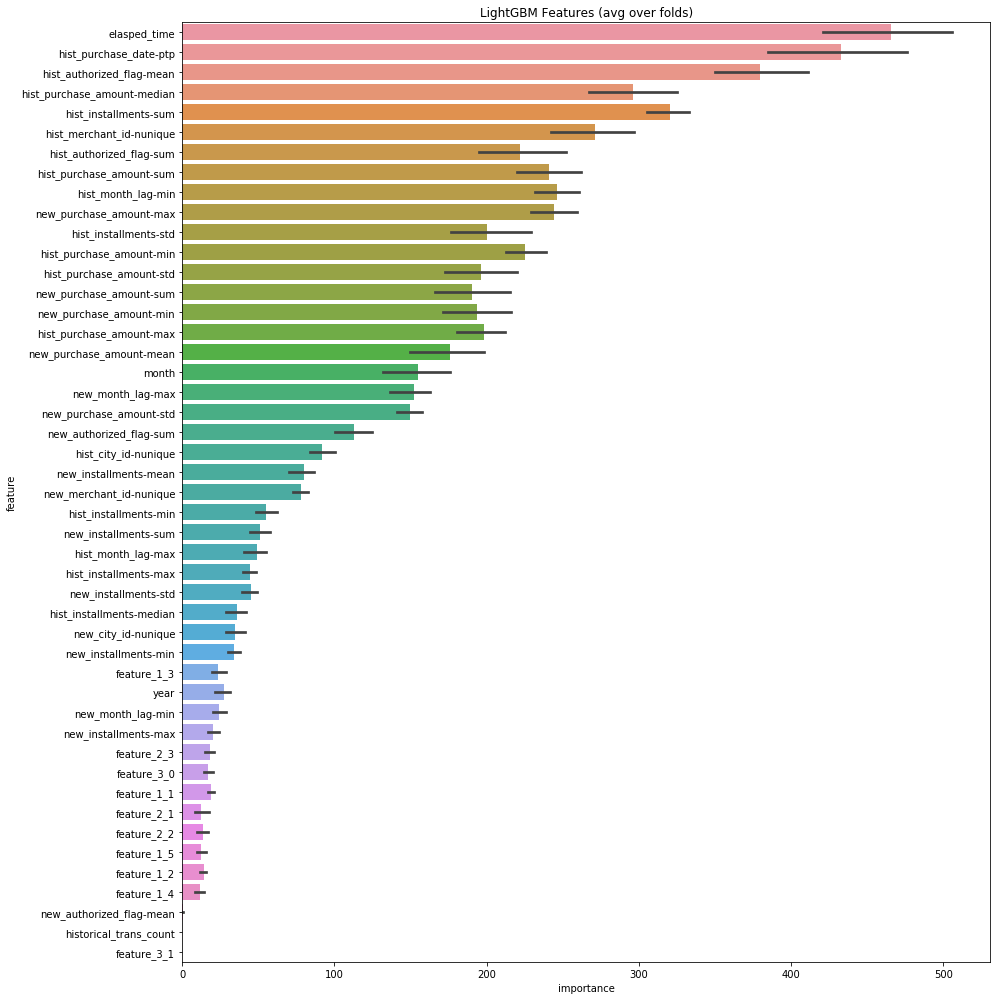

In [58]:
cols = (feature_importance_df_lgb1[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_lgb1.loc[feature_importance_df_lgb1.feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [59]:
# Reduced the feature to 5 most important features
most_important_features = [col for col in training_set.columns if col in ['elasped_time', 'hist_purchase_date-ptp', 
                                                                          'hist_authorized_flag-mean', 'hist_purchase_amount-median',
                                                                          'hist_installments-sum']]
training_set = training_set[most_important_features]


training_set.head()
training_set.shape

(201917, 5)

In [60]:
# Making prediction using the tuned parameters found using GridSearchCV

# Defining the tuned parameters that will be used in the LightGBM
lgb_params = {"objective" : "regression", "metric" : "rmse", 
              "max_depth": 8, "min_child_samples": 20,
              "reg_alpha": 0, "reg_lambda": 0,
              "num_leaves" : 75, "learning_rate" : 0.1, 
              "subsample" : 0.5, "colsample_bytree" : 0.8, 
              "verbosity": -1, 'min_data_in_leaf': 150,
              "feature_fraction": 1, "bagging_feature": 0.7,
              "lambda_l1": 6}

# Defining the parameters for the KFold cross validation that will be used
FOLDs = KFold(n_splits=5, shuffle=True, random_state=187)

# Creating a column of zeroes in the training and test sets that we will use for our predictions and validations set.
oof_lgb1 = np.zeros(len(training_set))
predictions_lgb1 = np.zeros(len(test_set))

# Using a for loop to cycle through all combinations of the training and test splits
for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(training_set)):
    trn_data = lgb.Dataset(training_set.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(training_set.iloc[val_idx], label=y_train.iloc[val_idx])

    # Training the data
    print('Fold', str(fold_), 'started at', time.ctime())
    num_round = 10000
    clf1 = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb1[val_idx] = clf1.predict(training_set.iloc[val_idx], num_iteration=clf1.best_iteration)
    
    # Making prediction on the validation set
    predictions_lgb1 += clf1.predict(test_set, num_iteration=clf1.best_iteration) / FOLDs.n_splits
    
# Printing the predictions and RMSE error of the model
cv_results_lgb1 = np.sqrt(mean_squared_error(oof_lgb1, y_train))
print(cv_results_lgb1)

Fold 0 started at Thu Dec 13 13:52:48 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[26]	training's rmse: 3.74391	valid_1's rmse: 3.76007
Fold 1 started at Thu Dec 13 13:52:50 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[36]	training's rmse: 3.72243	valid_1's rmse: 3.82498
Fold 2 started at Thu Dec 13 13:52:51 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[27]	training's rmse: 3.7383	valid_1's rmse: 3.78634
Fold 3 started at Thu Dec 13 13:52:52 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[24]	training's rmse: 3.73605	valid_1's rmse: 3.8122
Fold 4 started at Thu Dec 13 13:52:54 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[52]	training's rmse: 3.72852	valid_1's rmse: 3.74055
3.7849583283223325
